In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [3]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [4]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# dfi.export(data['data_nlp'], './images/data_nlp_sample.png')
data['data_nlp']

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_init
0,0,141.99,0.478022,-2.455034,138.99,104.11,0,0.900000,1.100000,1.000000
1,1,115.99,3.359042,-0.665581,112.99,87.67,1,0.900000,1.100000,1.000000
2,1,115.99,3.359042,-0.366413,112.99,87.67,2,0.900000,1.100000,1.000000
3,2,99.99,0.781950,-1.431336,91.99,73.00,3,0.900000,1.057991,0.978995
4,3,51.99,3.604018,-0.841617,50.99,39.53,4,0.900000,1.100000,1.000000
5,4,89.99,3.906002,-0.432880,97.99,120.56,5,0.925564,1.100000,1.012782


In [5]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
# dfi.export(data['data_milp'], './images/data_milp_sample.png')
data['data_milp']

,plu_line_idx,P,PC,C,Ps,Qs,xs,grid_size,P_idx,n_plu
0,0,141.99,138.99,104.11,"[127.99, 128.99, 130.99, 131.99, 132.99, 134.9...","[0.6089394539338445, 0.5985012724198178, 0.578...","[0.9014015071483906, 0.9084442566377914, 0.922...",21,10,1
1,1,115.99,112.99,87.67,"[103.99, 105.99, 106.99, 107.99, 108.99, 109.9...","[7.08731316001623, 7.0242781667422545, 6.99298...","[0.8965428054142598, 0.9137856711785499, 0.922...",21,10,2
2,2,99.99,91.99,73.00,"[89.99, 90.99, 91.99, 92.99, 93.99, 94.99, 95....","[0.9022928650366684, 0.889468741538329, 0.8768...","[0.8999899989999, 0.90999099909991, 0.91999199...",17,10,1
3,3,51.99,50.99,39.53,"[46.99, 47.99, 48.99, 49.99, 50.99, 51.99, 52....","[3.9078585400206394, 3.8451071816875837, 3.783...","[0.9038276591652241, 0.9230621273321793, 0.942...",11,5,1
4,4,89.99,97.99,120.56,"[82.99, 83.99, 84.99, 85.99, 86.99, 87.99, 88....","[4.039764869374558, 4.020379024402288, 4.00108...","[0.9222135792865874, 0.9333259251027892, 0.944...",17,7,1


### Отчет по времени работы и количеству "успешно" решенных задач

In [6]:
from runner import optimizers_collect_stat

In [7]:
stats_df = optimizers_collect_stat('./data/stat/')

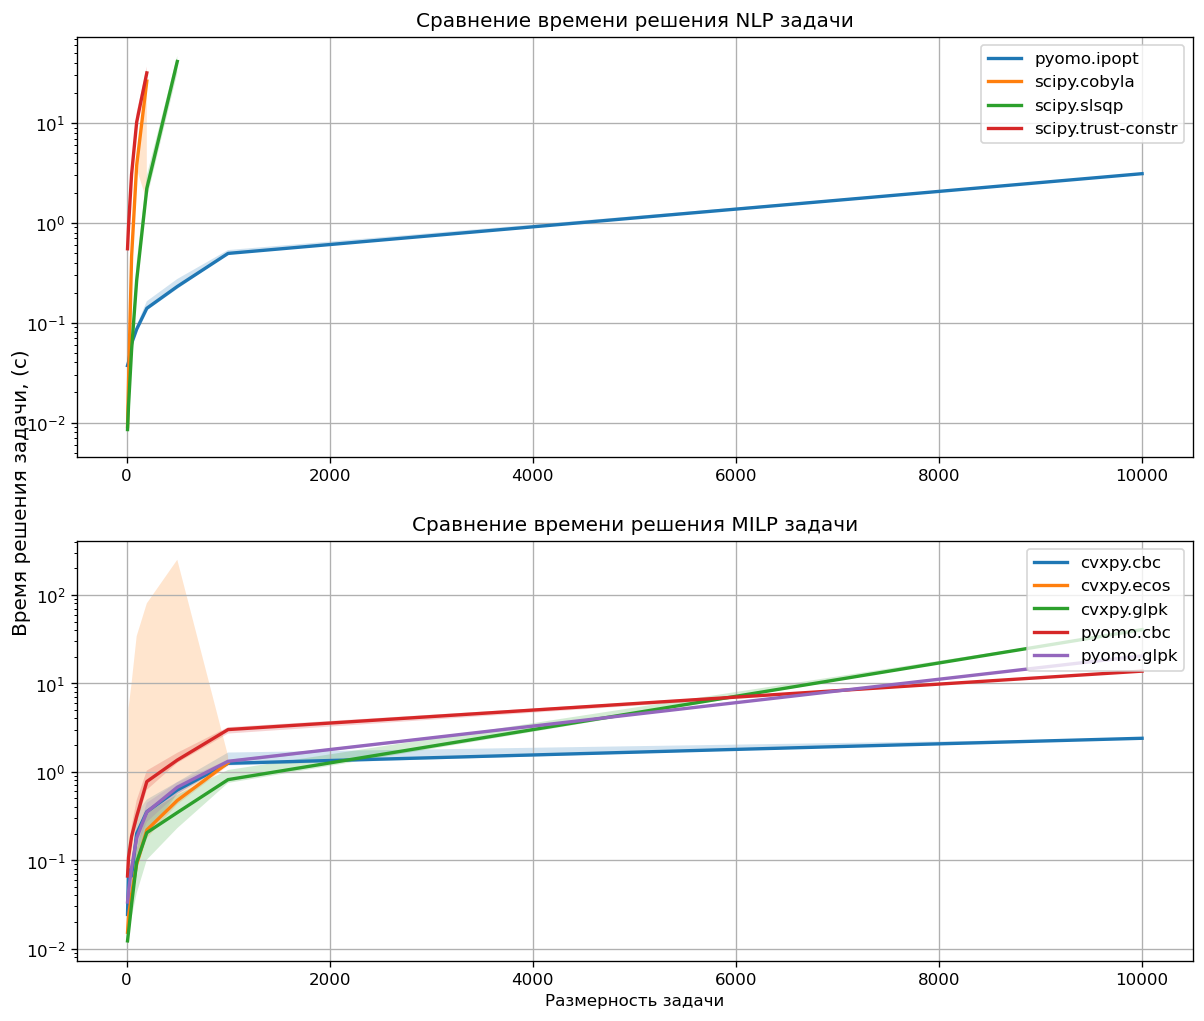

In [8]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['opt_type'] = np.where(
    stats_df['solver'].isin(['scipy.slsqp', 'scipy.trust-constr', 'scipy.cobyla' ,'pyomo.ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['opt_type', 'solver', 'N'])['t'].describe().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (opt_type, solver), df in time_rep_df.groupby(['opt_type', 'solver']):
    ax_id = 0 if opt_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=2, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Размерность задачи')
plt.savefig('./images/time_solve_compare.png')
plt.show()


In [10]:
success_rate_df =\
    stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})
# dfi.export(success_rate_df, './images/success_rate.png')
success_rate_df


,solver,success_rate
0,cvxpy.cbc,0.990521
1,cvxpy.ecos,0.700000
2,cvxpy.glpk,0.990521
3,pyomo.cbc,1.000000
4,pyomo.glpk,1.000000
5,pyomo.ipopt,1.000000
6,scipy.cobyla,0.513333
7,scipy.slsqp,0.955556
8,scipy.trust-constr,0.853333


### Пример запуска оптимизации(простой)

In [12]:
import numpy as np
from data_generator.data_generator import generate_data, price_round
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)


def calc_metrics(df, tp='cur'):
    sfx = ''
    if tp == 'cur':
        sfx = ''
    elif tp == 'opt':
        sfx = '_opt'
    R_ = sum(df['P' + sfx] * df['Q' + sfx])
    M_ = sum((df['P' + sfx] - df['C']) * df['Q' + sfx])
    return R_, M_


def perc_delta(v_old, v_new, ndigits=2):
    p = round(100. * (v_new / v_old - 1.), ndigits)
    sign = '+' if p >= 0 else '-'
    return sign + str(abs(p)) + '%'


bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
#
data = generate_data(50, bounds_params, grid_size, 0)
# текущая выручка и маржа
R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
# параметры для оптимизации
opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
}


"""
Тест расчёта на небольших данных
"""

res_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
res_milp = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')

R_opt_nlp, M_opt_nlp = calc_metrics(res_nlp['data'], 'opt')
R_opt_milp, M_opt_milp = calc_metrics(res_milp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче'.format(
    dR=perc_delta(R_cur, R_opt_nlp), dM=perc_delta(M_cur, M_opt_nlp)))
print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в MILP задаче'.format(
    dR=perc_delta(R_cur, R_opt_milp),
    dM=perc_delta(M_cur, M_opt_milp)))

res_nlp['data']['P_opt'] = price_round(res_nlp['data']['P_opt'])
res_nlp['data']['x_opt'] = res_nlp['data']['P_opt'] / res_nlp['data']['P']
res_nlp['data']['Q_opt'] = res_nlp['data']['Q'] * np.exp(res_nlp['data']['E'] * (res_nlp['data']['x_opt'] - 1))
R_opt_nlp_ar, M_opt_nlp_ar = calc_metrics(res_nlp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче после округления'.format(
    dR=perc_delta(R_cur, R_opt_nlp_ar), dM=perc_delta(M_cur, M_opt_nlp_ar)))

ind = res_nlp['data'].groupby(['plu_line_idx'])['x_opt'].nunique().max() == 1
print(f'Все товары в линейке имеют одинаковые цены: {ind}')


dR = +7.9%, dM = +0.0% - Изменение выручки и маржи в NLP задаче
dR = +7.87%, dM = +0.01% - Изменение выручки и маржи в MILP задаче
dR = +7.86%, dM = +0.62% - Изменение выручки и маржи в NLP задаче после округления
Все товары в линейке имеют одинаковые цены: True


### Пример запуска оптимизации(сложный)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [12]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_norm_res = np.zeros(N_grid)
M_norm_res = np.zeros(N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)


opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_norm_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt']) / R_cur
    M_norm_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt']) / M_cur

    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

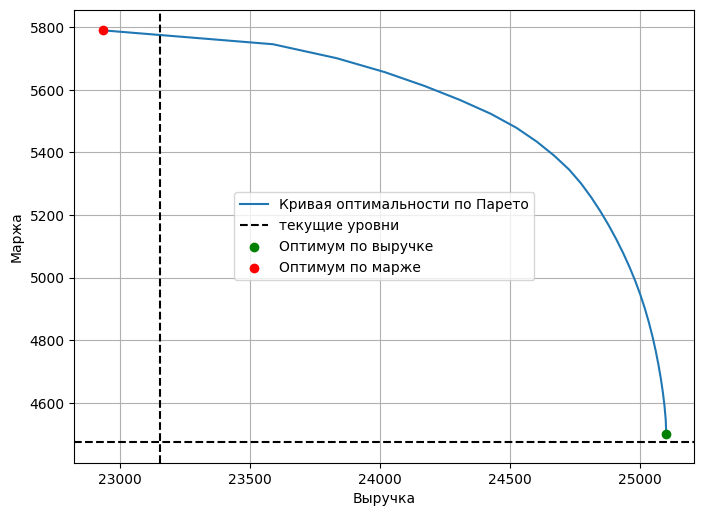

In [13]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

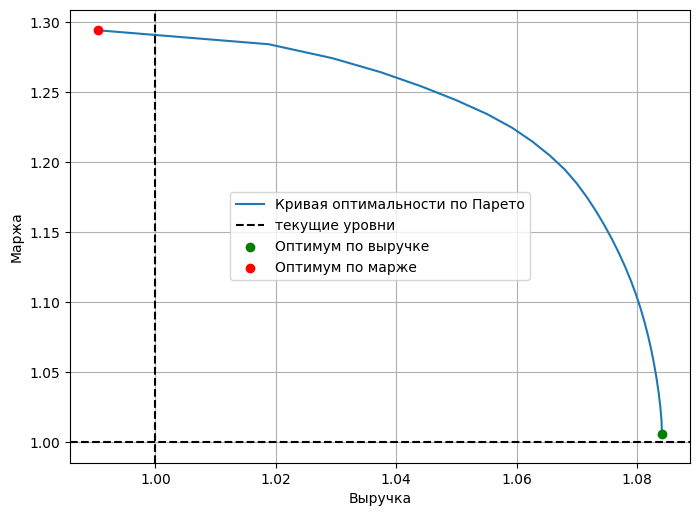

In [14]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_norm_res, M_norm_res, label='Кривая оптимальности по Парето')
plt.axvline(1, ls='--', c='k', label='текущие уровни')
plt.axhline(1, ls='--', c='k')
plt.scatter(R_norm_res[0], M_norm_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_norm_res[-1], M_norm_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Запус MINLP с pyomo

In [17]:
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import PyomoNlpOptimizationModel
from itertools import product

SEED_GRID = list(range(8))
N_GRID = list(range(5, 55, 5))
GRID = product(N_GRID, SEED_GRID)

bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
GRID_SIZE = 21
GRID = product(N_GRID, SEED_GRID)
minlp_stats_df_list = []

for N, seed in GRID:
    print(N, seed)
    data = generate_data(N, bounds_params, GRID_SIZE, seed)
    N_plu = len(data['data_nlp'])
    # текущая выручка и маржа
    R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
    # параметры для оптимизации
    opt_params = {
        'alpha': 0.0,
        'con_mrg': M_cur,
        'con_chg_cnt':  int(0.7 * N_plu)
    }
    res_minlp, t_minlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'bonmin')
    minlp_stats_df_list.append(pd.DataFrame({
        'N': [N],
        'seed': [seed],
        't': [t_minlp],
        'status': [res_minlp['status']]
    }))
    
    print('minlp finished at %.3f' % t_minlp)
    print('--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--')
minlp_stats_df = pd.concat(minlp_stats_df_list)

minlp_stats_df.to_csv('./data/stat_minlp/stat.csv', index=None)

5 0
minlp finished at 0.346
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 1
minlp finished at 0.310
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 2
minlp finished at 0.289
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 3
minlp finished at 0.640
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 4
minlp finished at 0.722
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 5
minlp finished at 0.799
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 6
minlp finished at 0.376
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 7
minlp finished at 2.493
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 0
minlp finished at 1.051
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 1
minlp finished at 2.702
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 2
minlp finished at 3.064
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

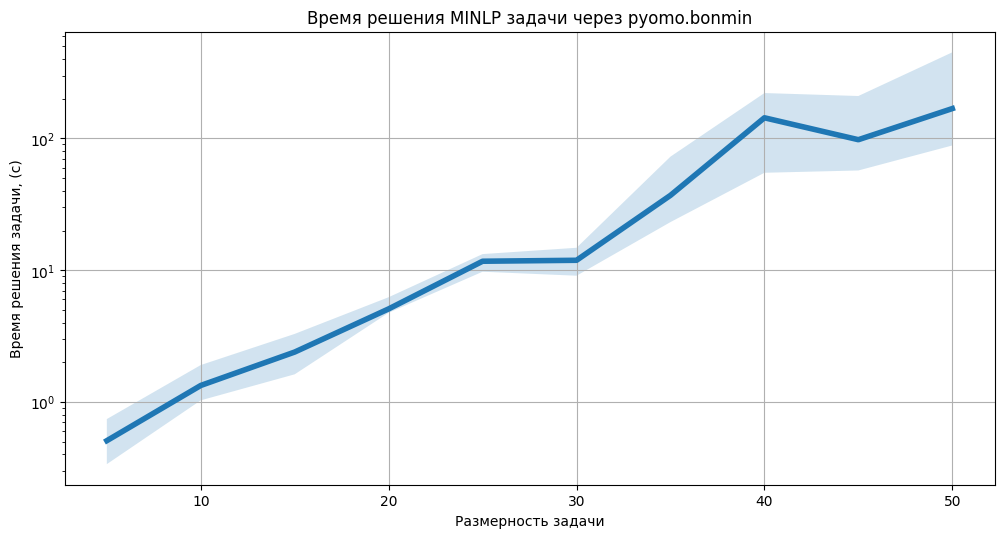

In [25]:
minlp_stats_df = pd.read_csv('./data/stat_minlp/stat.csv')
time_rep_df = minlp_stats_df.groupby(['N'])['t'].describe().reset_index()

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(time_rep_df['N'], time_rep_df['50%'], lw=4)
plt.fill_between(time_rep_df['N'], time_rep_df['25%'], time_rep_df['75%'], alpha=0.2)
# x = np.linspace(5, 30å, 100)
# y = 2.0e-1 * np.exp(0.225 * x)
# plt.plot(x, y)
plt.yscale('log')
plt.xlabel('Размерность задачи')
plt.ylabel('Время решения задачи, (с)')
plt.title('Время решения MINLP задачи через pyomo.bonmin')
plt.grid()
plt.savefig('./images/time_solve_minlp.png')
plt.show()

### Сравнение решений оптимизаторов

In [13]:
%%time
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21


data = generate_data(50, bounds_params, 21,)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur
}

CPU times: user 67.5 ms, sys: 2.28 ms, total: 69.8 ms
Wall time: 69 ms


In [17]:
%%time
try:
    res_1 = pricing_optimization(data, PyomoLpOptimizationModel, opt_params, 'glpk')
    print(res_1['t'])
except Exception as e:
    print(e)

0.07732915878295898
CPU times: user 46.5 ms, sys: 14.8 ms, total: 61.3 ms
Wall time: 77.5 ms


In [21]:
%%time
try:
    res_2 = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    print(res_2['t'])
except Exception as e:
    print(e)

0.02051377296447754
CPU times: user 20.2 ms, sys: 1.62 ms, total: 21.8 ms
Wall time: 20.7 ms


In [22]:
df = res_1['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

10548.910129190795 9779.051888774215
1552.1169709505468 1551.9890324484256


In [23]:
df = res_2['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

10548.910129190795 9779.051888774215
1552.1169709505468 1551.9890324484256


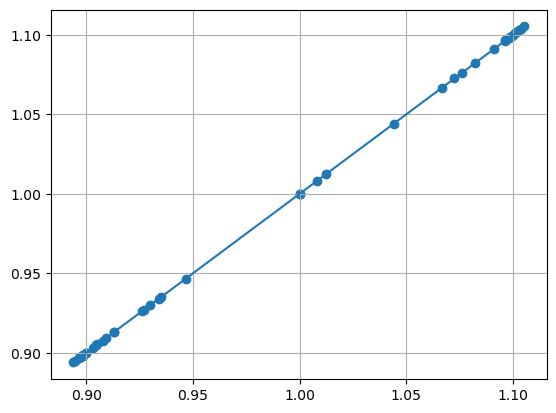

In [24]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

### Тестовые примеры с pytest

In [26]:
from data_generator.data_generator import generate_data

N = 10
GRID_MAX_SIZE = 21
BOUNDS_PARAMS = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}


def test_generate_data():
    """

    """
    data = generate_data(N, BOUNDS_PARAMS, GRID_MAX_SIZE, 0)

    




In [67]:
data = generate_data(N, BOUNDS_PARAMS, GRID_MAX_SIZE, 0)

# проверка что есть все поля в генерируемых данных
keys = set(data.keys())
need_keys = {'data_nlp', 'data_milp', 'plu_idx_in_line'}
keys_diff = need_keys - keys 
assert len(keys_diff) == 0, 'не хватает поле в data: %s' % keys_diff
# проверка наличия необходимых полей в data_nlp
data_nlp = data['data_nlp']
cols_nlp = set(data_nlp.columns)
need_cols_nlp = {'plu_idx', 'plu_line_idx', 'P', 'PC', 'Q', 'C', 'x_lower', 'x_upper'}
cols_nlp_diff = need_cols_nlp - cols_nlp
assert len(cols_nlp_diff) == 0, 'в data_nlp не хватает колонок: %s' % cols_nlp_diff
# проверка наличия необходимых полей в
data_milp = data['data_milp']
cols_milp = set(data_milp.columns)
need_cols_milp = {'plu_line_idx', 'Ps', 'Qs', 'C', 'xs', 'grid_size', 'P_idx', 'n_plu'}
cols_milp_diff = need_cols_milp - cols_milp
assert len(cols_milp_diff) == 0, 'в data_nlp не хватает колонок: %s' % cols_milp_diff

In [66]:
need_cols_milp - cols_milp

set()